# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading libraries

In [1]:
import os
import time
import pickle
import numpy as np
import tensorflow as tf
from __future__ import print_function
from tqdm import tqdm
from urllib import urlretrieve
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

from helpers import display_sample_images, preprocess_images, one_hot_encode, batch_creator

%matplotlib inline
tf.reset_default_graph()

## Loading VGG-16 trained model

In [2]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('./tensorflow_vgg/vgg16.npy'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            './tensorflow_vgg/vgg16.npy',
            pbar.hook)

from tensorflow_vgg import vgg16
print('Model loaded!')

Model loaded!


## Load the dataset

In [3]:
if not os.path.isfile('../data/train_32x32.mat'):
    os.mkdir('../data')
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            '../data/train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('../data/train_32x32.mat')
print('Data loaded!')

Data loaded!


## Understanding the dataset

In [4]:
print(type(svhn_data))
print(svhn_data.keys())

<type 'dict'>
['y', 'X', '__version__', '__header__', '__globals__']


In [5]:
features = svhn_data['X']
labels = svhn_data['y']

print('X: {} ({} x {} x {}) images'.format(features.shape[3], features.shape[0],
                                           features.shape[1], features.shape[2]))
print('y: {} ({}) labels'.format(labels.shape[0], labels.shape[1]))
print('First 30 labels: {}'.format(labels[:30].reshape((1,-1))))
print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

X: 73257 (32 x 32 x 3) images
y: 73257 (1) labels
First 30 labels: [[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8 1 6 2 3 6 3 4 2 5 8]]
Label Counts: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


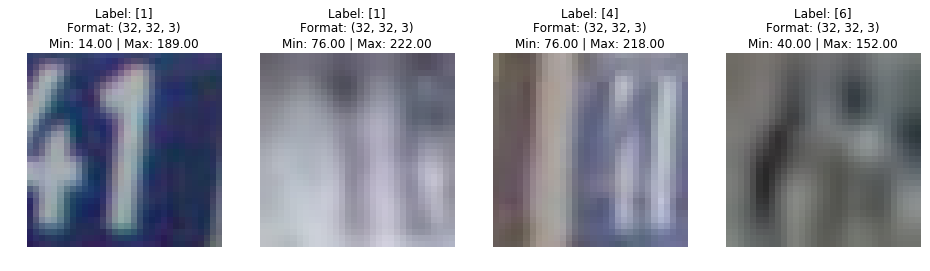

In [6]:
display_sample_images(features, labels, 4)

## Transfering learning (using a trained net)

In [7]:
if not os.path.isfile('./code_data.pkl'):
    batch_size = 8
    codes = None
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        images = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope('content_vgg'):
            vgg.build(images)
    
        for batch, _ in tqdm(batch_creator(features, labels, batch_size), desc='Training'):
            processed_batch = preprocess_images(batch)
            feed_dict = {images: processed_batch}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
        
    with open('./code_data.pkl', 'wb') as f:
        pickle.dump(codes, f)

## Preporcessing part trained data

In [8]:
with open('./code_data.pkl', 'rb') as f:
    codes = pickle.load(f)
print(codes.shape)

(73257, 4096)


In [9]:
def normalize_data(features):
    return (features - np.mean(features)) / np.std(features)

norm_codes = normalize_data(codes)
print(np.min(norm_codes), np.max(norm_codes))

-0.40561 19.913


In [10]:
one_hot_labels = one_hot_encode(labels)
print(one_hot_labels.shape)

(73257, 10)


In [11]:
reduce_data = 20000

In [12]:
total_size = codes.shape[0]

if reduce_data is not None:
    total_size = reduce_data

train_size = 0.6
idx = np.arange(total_size)
np.random.shuffle(idx)
idx = list(idx)
split_point = int(total_size * train_size)
train_idx = idx[:split_point]
test_idx = idx[split_point:]

In [13]:
X_train = norm_codes[train_idx]
y_train = one_hot_labels[train_idx]
X_test = norm_codes[test_idx]
y_test = one_hot_labels[test_idx]

print('Train features: {} | Test features: {}'.format(X_train.shape, X_test.shape))
print('Train labels:   {}   | Test labels:   {}'.format(y_train.shape, y_test.shape))

Train features: (12000, 4096) | Test features: (8000, 4096)
Train labels:   (12000, 10)   | Test labels:   (8000, 10)


## Building the Neural Net

In [26]:
def fully_conn(x_tensor, num_outputs, activation=False):
    W = tf.Variable(tf.truncated_normal([int(x_tensor.get_shape()[1]),num_outputs], stddev=0.1))
    b = tf.Variable(tf.zeros([num_outputs]))
    net = tf.matmul(x_tensor, W) + b
    if activation:
        net = tf.nn.relu(net)
    return net

In [27]:
inputs_ = tf.placeholder(tf.float32, [None, codes.shape[1]])
labels_ = tf.placeholder(tf.float32, [None, one_hot_labels.shape[1]])
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

with tf.name_scope('fully_conn_content'):
    # continues the VGG16 architecture
    relu6 = tf.nn.relu(inputs_)
    drop6 = tf.nn.dropout(relu6, keep_prob)
    fc7 = fully_conn(drop6, 4096, True)
    drop7 = tf.nn.dropout(fc7, keep_prob)
    logits = fully_conn(drop7, one_hot_labels.shape[1])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_), name='cost')

with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Trainning the model

In [28]:
epochs = 300
batch_size = 10240
val_size = 0.2
learn_rate = 0.01
keep_probability = 0.5
display_epoch = 10

In [29]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    if os.path.isdir('./checkpoints'):
        saver.restore(sess, "./checkpoints/svhn.ckpt")
        print('Trained model loaded!')
    else:
        for epoch in range(epochs):
            train_total_loss = 0
            train_total_acc = 0
            val_total_loss = 0
            val_total_acc = 0
            for feat_train, feat_val, lab_train, lab_val in batch_creator(X_train, y_train, batch_size, val_size, flatted=True):
                train_dict = {inputs_: feat_train,
                              labels_: lab_train,
                              learning_rate: learn_rate,
                              keep_prob: keep_probability
                             }
                _, train_loss, train_acc = sess.run([optimizer, cost, accuracy], feed_dict = train_dict)
                
                val_dict = {inputs_: feat_val,
                            labels_: lab_val,
                            keep_prob: 1.0
                           }
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict = val_dict)
            output = 'Epoch {:4d} | Train loss {:.3f} | Train acc {:.3f} | Val loss {:.3f} | Val acc {:.3f}'
            print(output.format(epoch, train_loss, train_acc, val_loss, val_acc))
            
        !mkdir ./checkpoints
        saver.save(sess, "./checkpoints/svhn.ckpt")

NotFoundError: Key optimizer/beta2_power not found in checkpoint
	 [[Node: save_4/RestoreV2_25 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/RestoreV2_25/tensor_names, save_4/RestoreV2_25/shape_and_slices)]]

Caused by op u'save_4/RestoreV2_25', defined at:
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-a0c42fa2280e>", line 6, in <module>
    saver = tf.train.Saver()
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key optimizer/beta2_power not found in checkpoint
	 [[Node: save_4/RestoreV2_25 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/RestoreV2_25/tensor_names, save_4/RestoreV2_25/shape_and_slices)]]


## Test

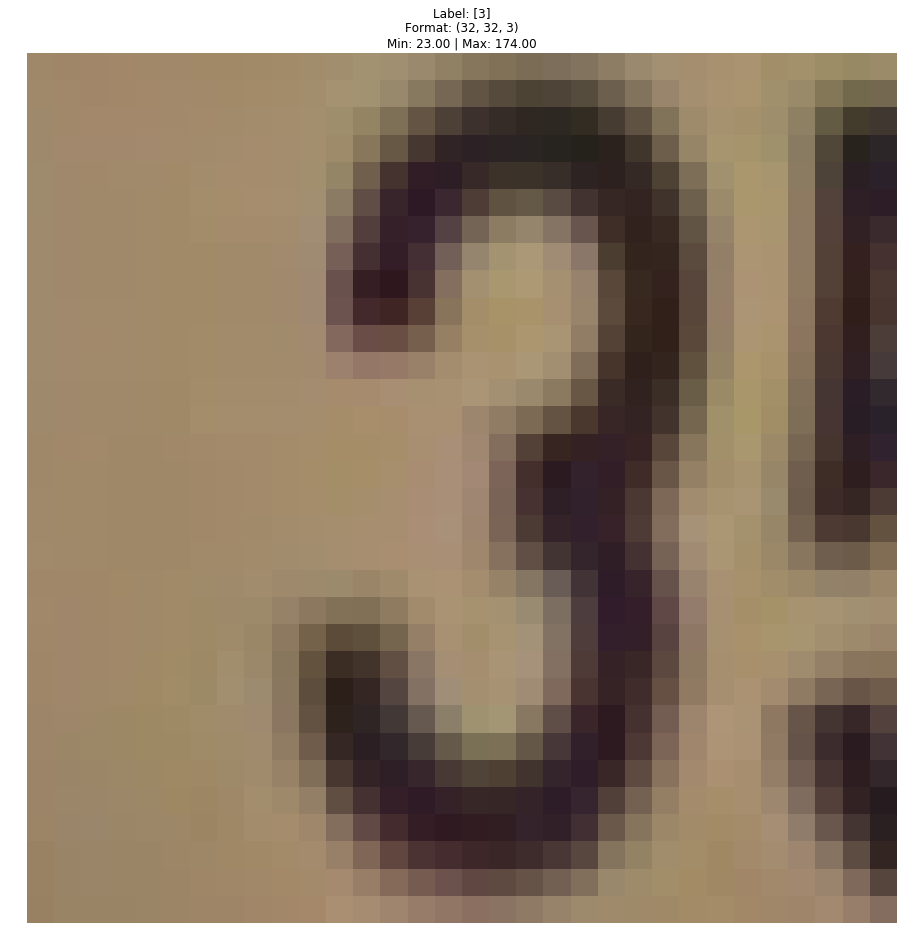

In [75]:
sample_image = np.random.choice(test_idx)
display_sample_images(features, labels, 1, test_data=sample_image)

In [84]:
sample_image_code = np.where(text_idx == sample_image)

print(sample_image)

"""

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    test_dict = {inputs_: X_test[].reshape((-1, 4096)),
                labels_: y_test[sample_image].reshape((-1, 10)),
                keep_prob: 1.0
               }
    prediction = sess.run(predicted, feed_dict=test_dict)
print('Predicted: {}'.format(np.argmax(prediction, 1)))
"""

Predicted: [4]
